# <h1 style="text-align:center;">Task 8: Root Length Prediction Pipeline</h1>

## Overview

----

This notebook implements a computer vision pipeline to predict primary root lengths from plant images. The pipeline:

1. Takes raw plant images as input
2. Uses deep learning for root segmentation 
3. Performs root architecture analysis
4. Outputs primary root length measurements for each plant

The predictions are submitted to a Kaggle competition for evaluation.

Key requirements:
- Pipeline must use deep learning for root segmentation
- Only inference/processing code (no training)
- Target sMAPE < 45% on private leaderboard

<br>

## Initial Setup

---

In [3]:
# Import the libraries
import os
import cv2
import glob
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from skimage.morphology import skeletonize
from skimage.graph import route_through_array
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Optional
from tqdm import tqdm
import os
import sys

In [10]:
# Add the paths to task5 and task7 directories and add them to Python path
task5_dir = os.path.join(os.getcwd(), '..', 'task5')
task7_dir = os.path.join(os.getcwd(), '..', 'task7')
import sys
sys.path.append(task5_dir)
sys.path.append(task7_dir)

# Import modules from task5 and task7
import inference
from RAA import RootArchitectureAnalyzer

<br>

## Load Model

---


In this section, we will initialize a U-Net model with a 960x960 pixel input size for single-channel (grayscale) images and load pre-trained weights from 'best_model.weights.h5' to perform root segmentation.

In [11]:
# Patch size
patch_size = 960

# Build U-Net
model = inference.unet_model(
    IMG_HEIGHT=patch_size,
    IMG_WIDTH=patch_size,
    IMG_CHANNELS=1
)

# Load the weight if it exists
# model.load_weights(f'soheil_6989490_unet_model_{patch_size}px.h5')
model.load_weights('./../task5/best_model.weights.h5')

/mnt/e/University/2024-25b-fai2-adsai-SoheilMohammadpour231754/datalab_tasks/task8/../task5/inference.py:200: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(
/home/bluestargaze/miniconda3/envs/cv/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 272 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


<br>

## Run CV Pipeline

---


In this section, we will test our root analysis pipeline on a single image by loading it, generating predictions using our trained model, processing the mask to extract root data, and visualizing the results using the RootArchitectureAnalyzer class.

Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


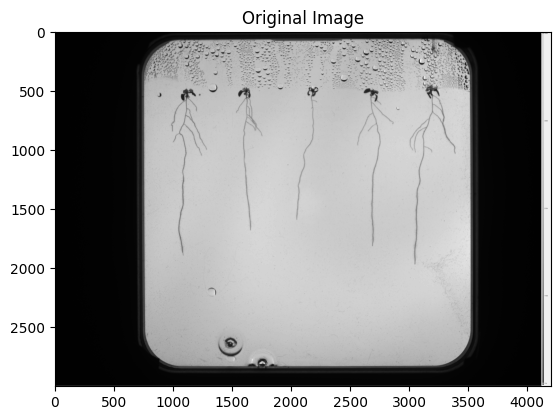

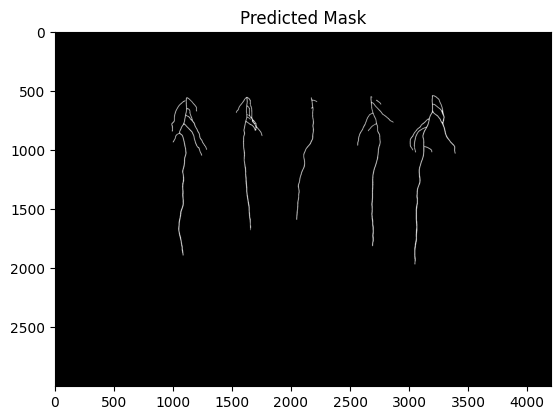

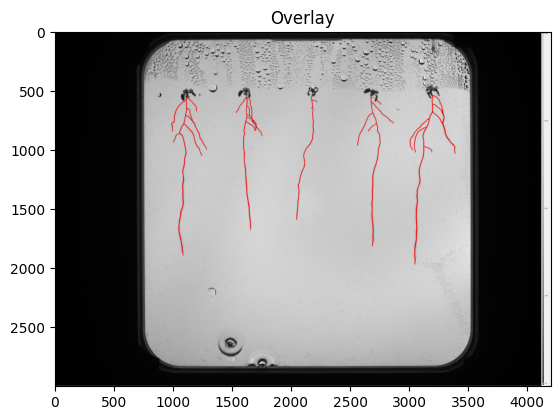

In [18]:
# Image path
image_path = glob.glob('./../task6/Kaggle/*.png')[4]

# Get predictions
mask, overlay = inference.predict_roots(image_path, model)

# Plot image, mask, and overlay
plt.imshow(cv2.imread(image_path, 0), cmap='gray')
plt.title('Original Image')
plt.show()
plt.imshow(mask, cmap='gray')
plt.title('Predicted Mask')
plt.show()
plt.imshow(overlay, cmap='gray')
plt.title('Overlay')
plt.show()

In [19]:
# Initialize analyzer
analyzer = RootArchitectureAnalyzer()

# Process the mask and get both root data and DataFrame
root_data, root_df, tip_coordinates = analyzer.process_image(
    mask=mask,
    original_image=cv2.imread(image_path, 0)  # Load original image in grayscale
)

In [22]:
root_df

skeleton-id  node-id-src  node-id-dst  branch-distance  branch-type  \
0               1            0            1         1.414214            1   
1               1            1            2         1.000000            1   
2               1            2            3         1.414214            1   
3               1            3            4         1.414214            1   
4               1            4            5         1.000000            1   
...           ...          ...          ...              ...          ...   
6178            5         1423         1424         1.000000            1   
6179            5         1424         1425         1.414214            1   
6180            5         1425         1426         1.414214            1   
6181            5         1426         1427         1.000000            1   
6182            5         1427         1428         1.000000            1   

      mean-pixel-value  stdev-pixel-value  image-coord-src-0  \
0                  1.0                0.0                557   
1                  1.0                0.0                558   
2                  1.0                0.0                559   
3                  1.0                0.0                560   
4                  1.0                0.0                561   
...                ...                ...                ...   
6178               1.0                0.0               1961   
6179               1.0                0.0               1962   
6180               1.0                0.0               1963   
6181               1.0                0.0               1964   
6182               1.0                0.0               1965   

      image-coord-src-1  image-coord-dst-0  image-coord-dst-1  coord-src-0  \
0                  1114                558               1113          557   
1                  1113                559               1113          558   
2                  1113                560               1112          559   
3                  1112                561               1111          560   
4                  1111                562               1111          561   
...                 ...                ...                ...          ...   
6178               3043               1962               3043         1961   
6179               3043               1963               3042         1962   
6180               3042               1964               3043         1963   
6181               3043               1965               3043         1964   
6182               3043               1966               3043         1965   

      coord-src-1  coord-dst-0  coord-dst-1  euclidean-distance  has_root  
0            1114          558         1113            1.414214      True  
1            1113          559         1113            1.000000      True  
2            1113          560         1112            1.414214      True  
3            1112          561         1111            1.414214      True  
4            1111          562         1111            1.000000      True  
...           ...          ...          ...                 ...       ...  
6178         3043         1962         3043            1.000000      True  
6179         3043         1963         3042            1.414214      True  
6180         3042         1964         3043            1.414214      True  
6181         3043         1965         3043            1.000000      True  
6182         3043         1966         3043            1.000000      True  

[6183 rows x 17 columns]

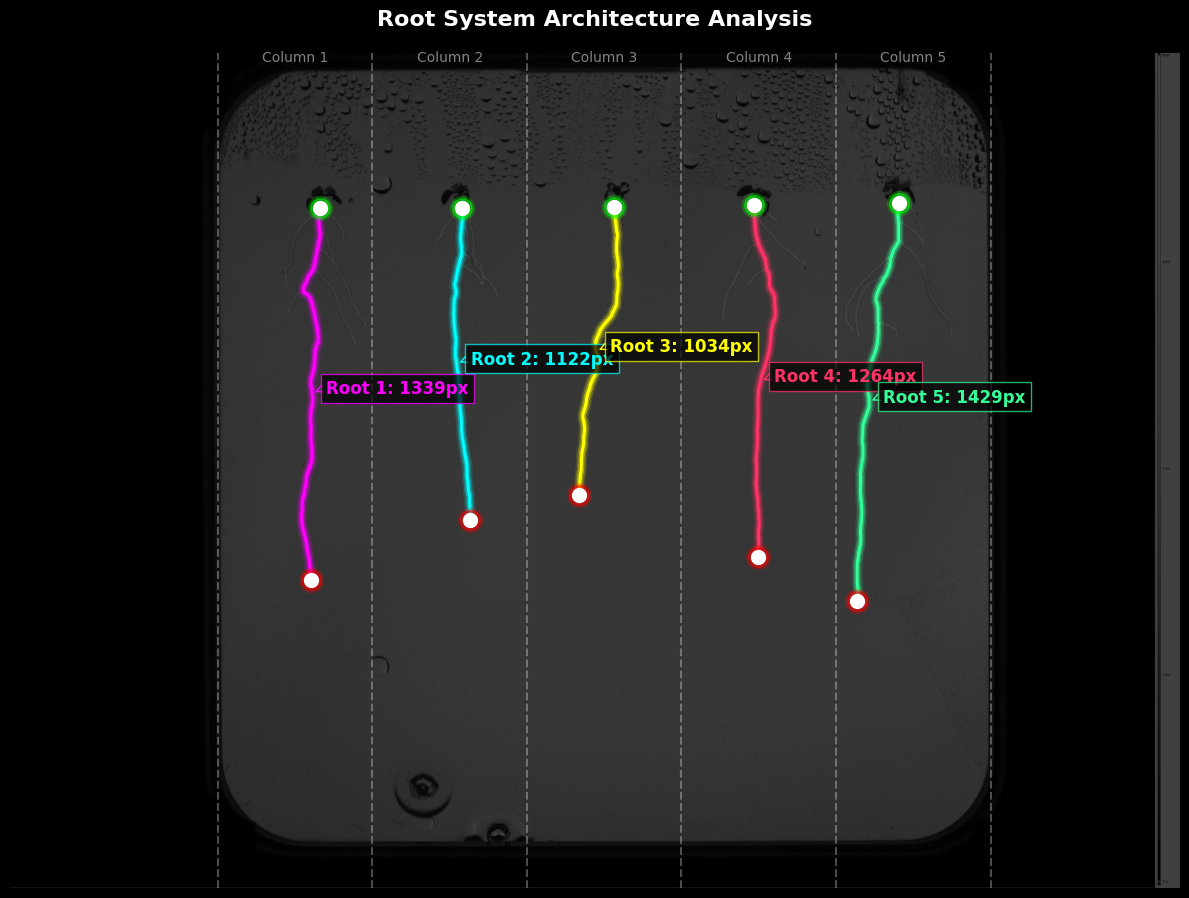

In [20]:
# Visualize the roots
analyzer.visualize_results(
    root_data=root_data,
    original_mask=mask,
    original_image=cv2.imread(image_path, 0)
)

In [5]:
# sections = analyzer.divide_into_sections(mask)
# analyzer.visualize_sections(mask, sections)

In [6]:
# complete_df["Plant ID"].sort_values().unique()
# assert 0 == 1

Processing images:   0%|          | 0/18 [00:00<?, ?it/s]

Processing image: test_image_1...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


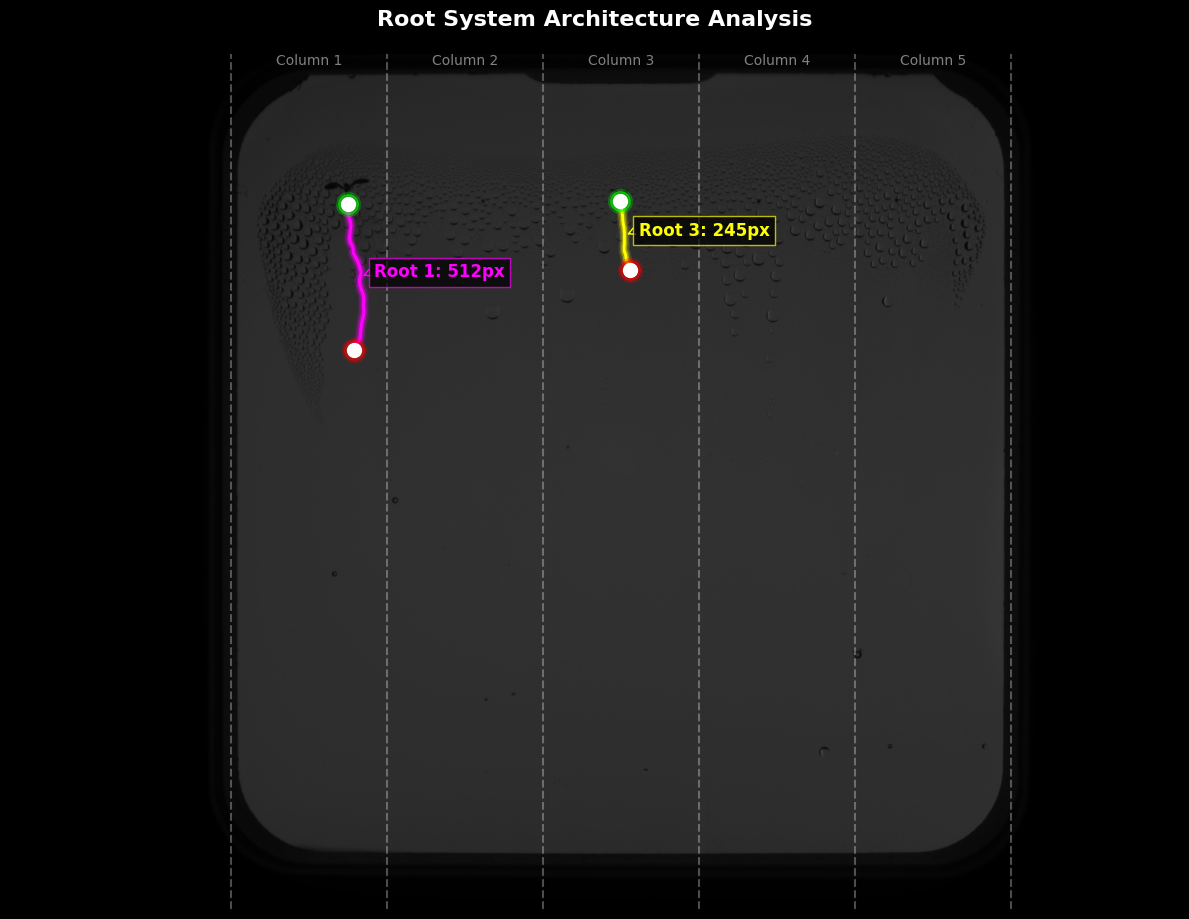

Processing images:   6%|▌         | 1/18 [00:05<01:34,  5.57s/it]


Root data structure for first plant:
dict_keys(['column', 'has_root', 'length', 'area', 'path', 'mask', 'bounds'])


Processing image: test_image_10...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


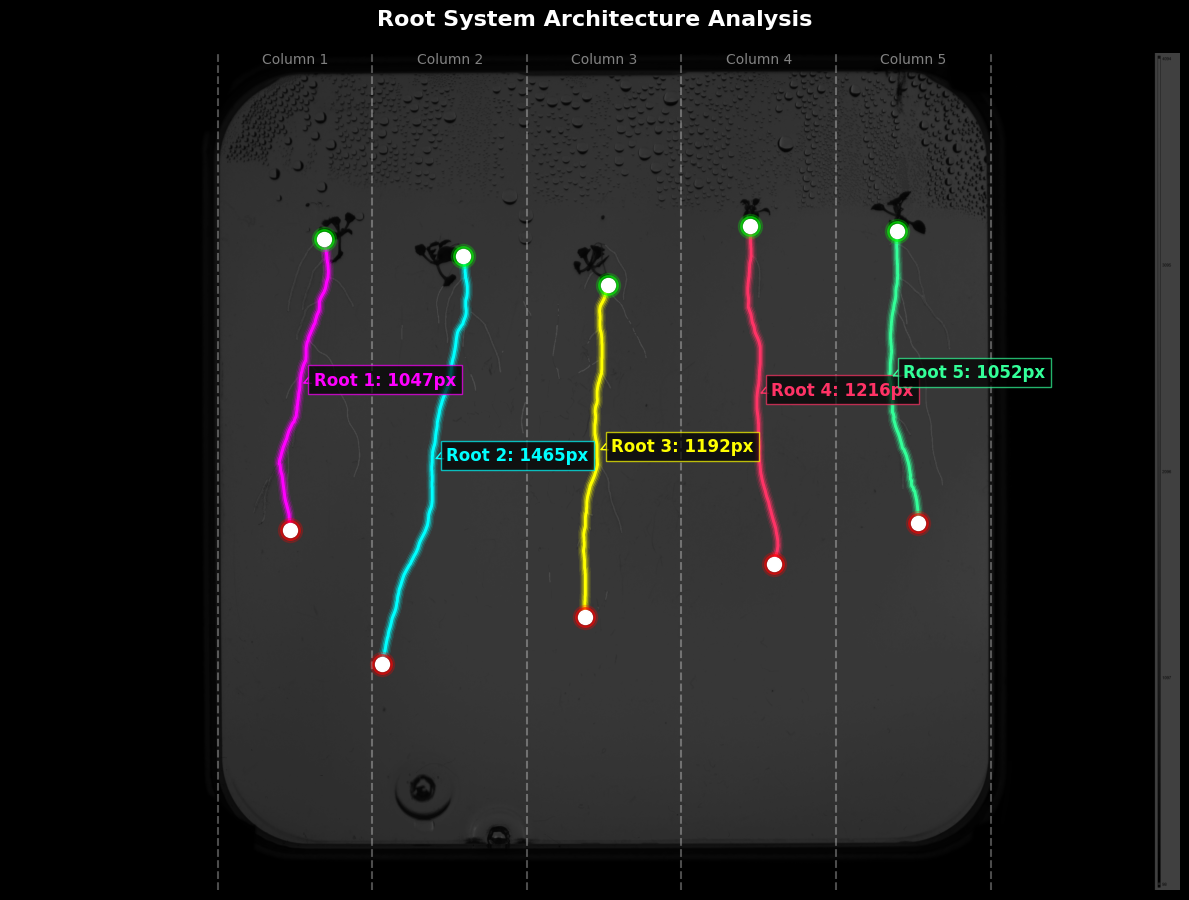

Processing images:  11%|█         | 2/18 [01:12<11:05, 41.60s/it]

Processing image: test_image_11...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


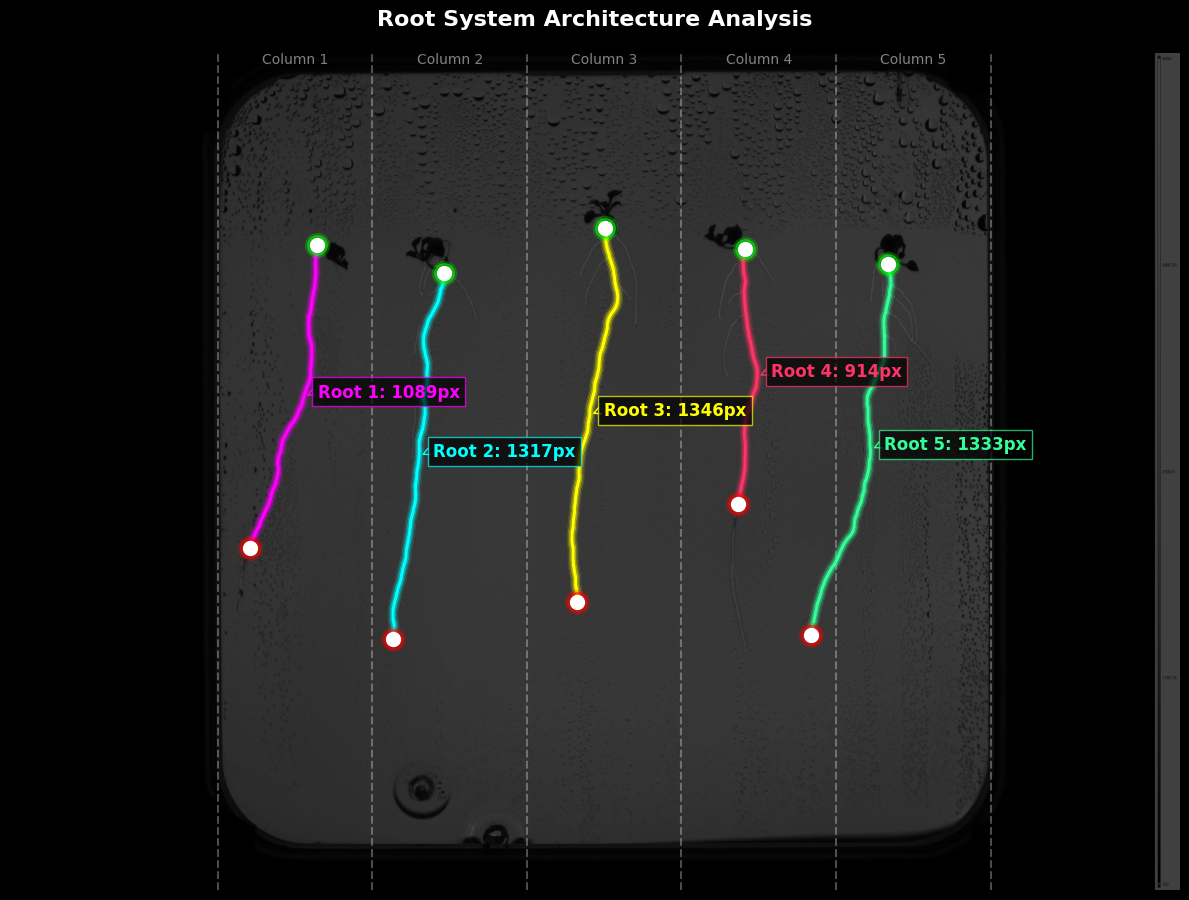

Processing images:  17%|█▋        | 3/18 [01:58<10:55, 43.71s/it]

Processing image: test_image_12...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


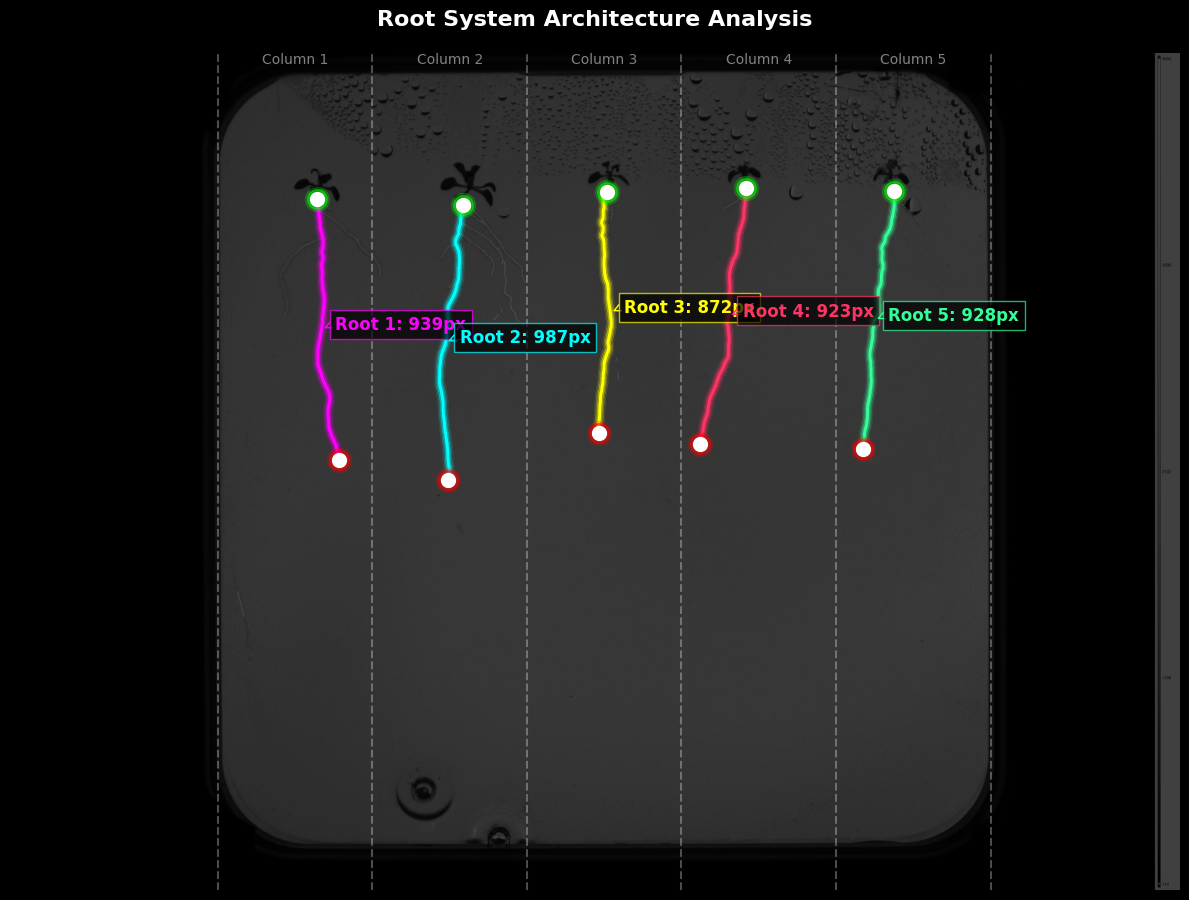

Processing images:  22%|██▏       | 4/18 [02:31<09:11, 39.42s/it]

Processing image: test_image_13...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


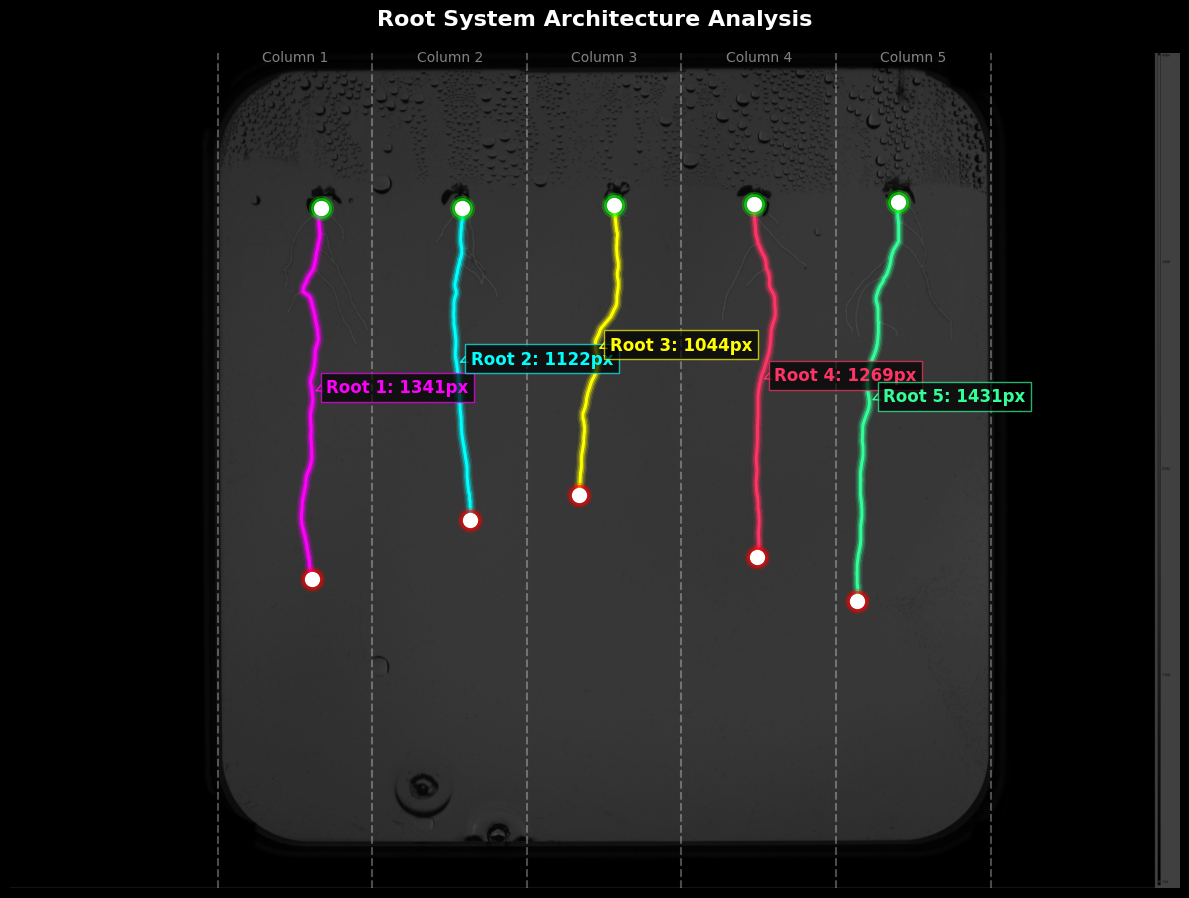

Processing images:  28%|██▊       | 5/18 [02:58<07:32, 34.83s/it]

Processing image: test_image_14...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


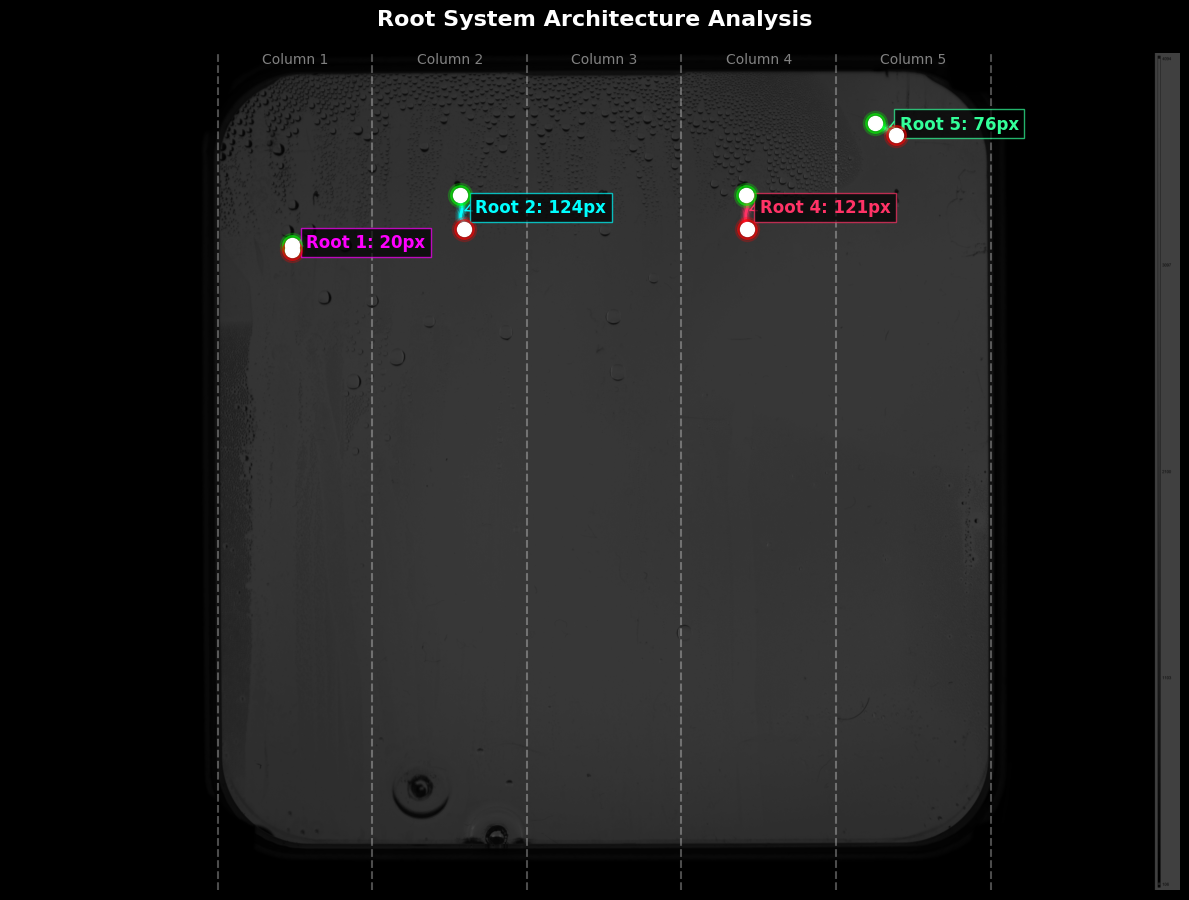

Processing images:  33%|███▎      | 6/18 [03:11<05:32, 27.67s/it]

Processing image: test_image_15...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


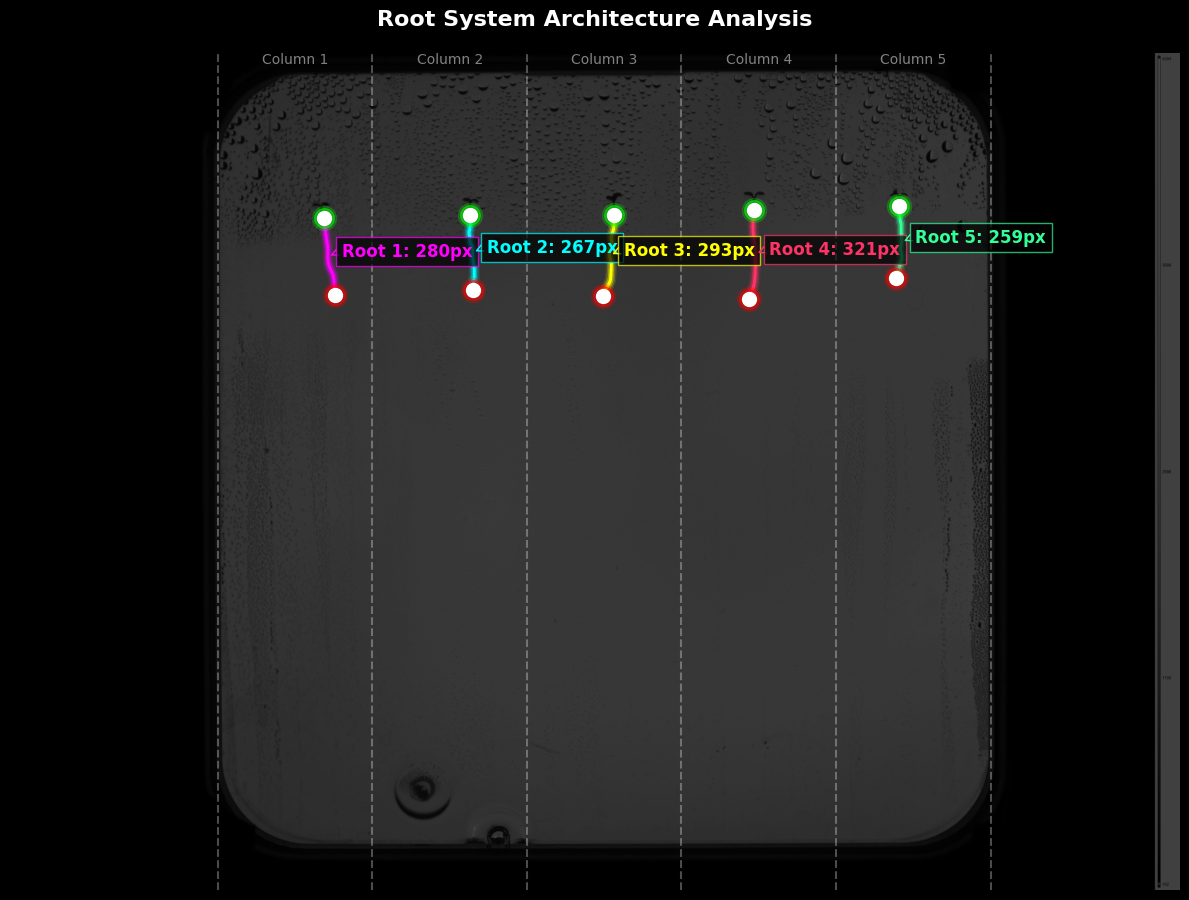

Processing images:  39%|███▉      | 7/18 [03:22<04:02, 22.00s/it]

Processing image: test_image_16...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


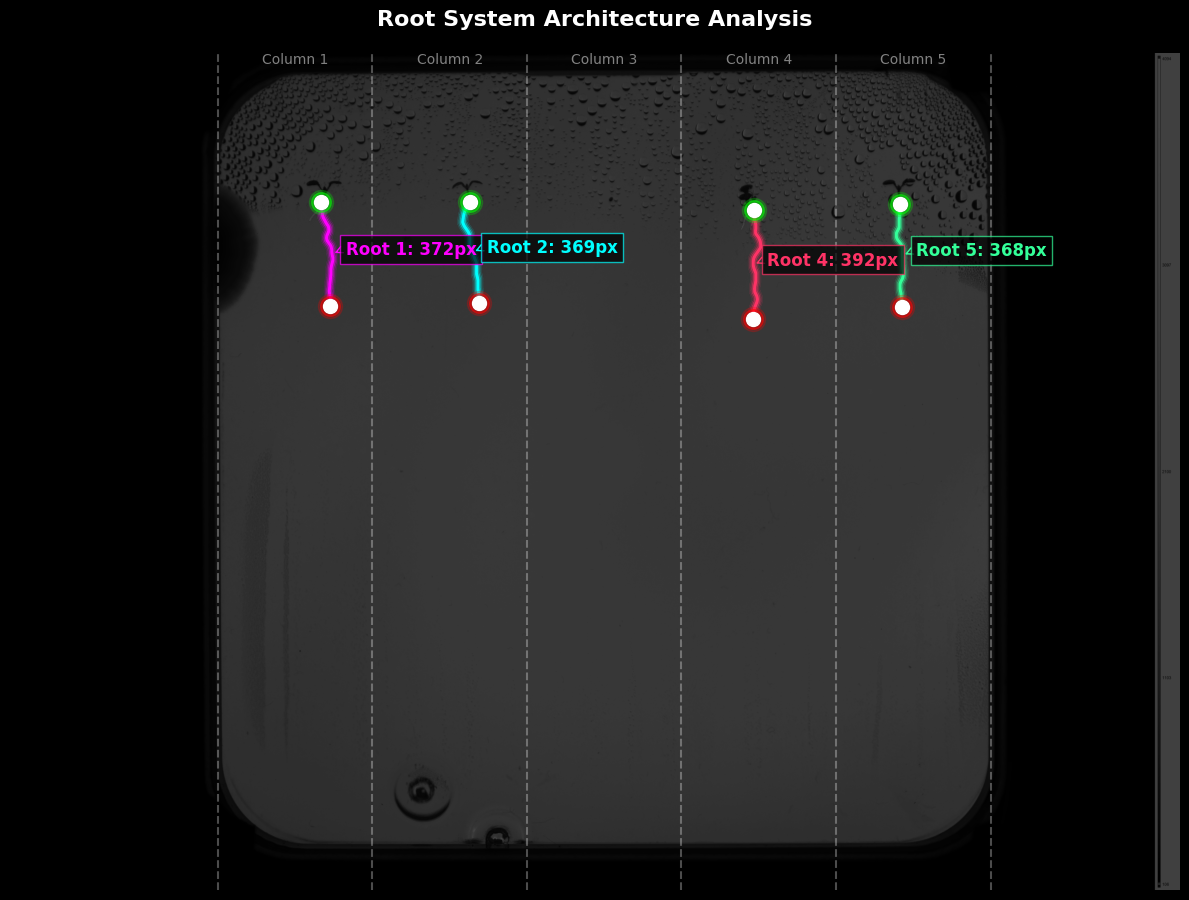

Processing images:  44%|████▍     | 8/18 [03:37<03:18, 19.81s/it]

Processing image: test_image_17...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)
No valid path found


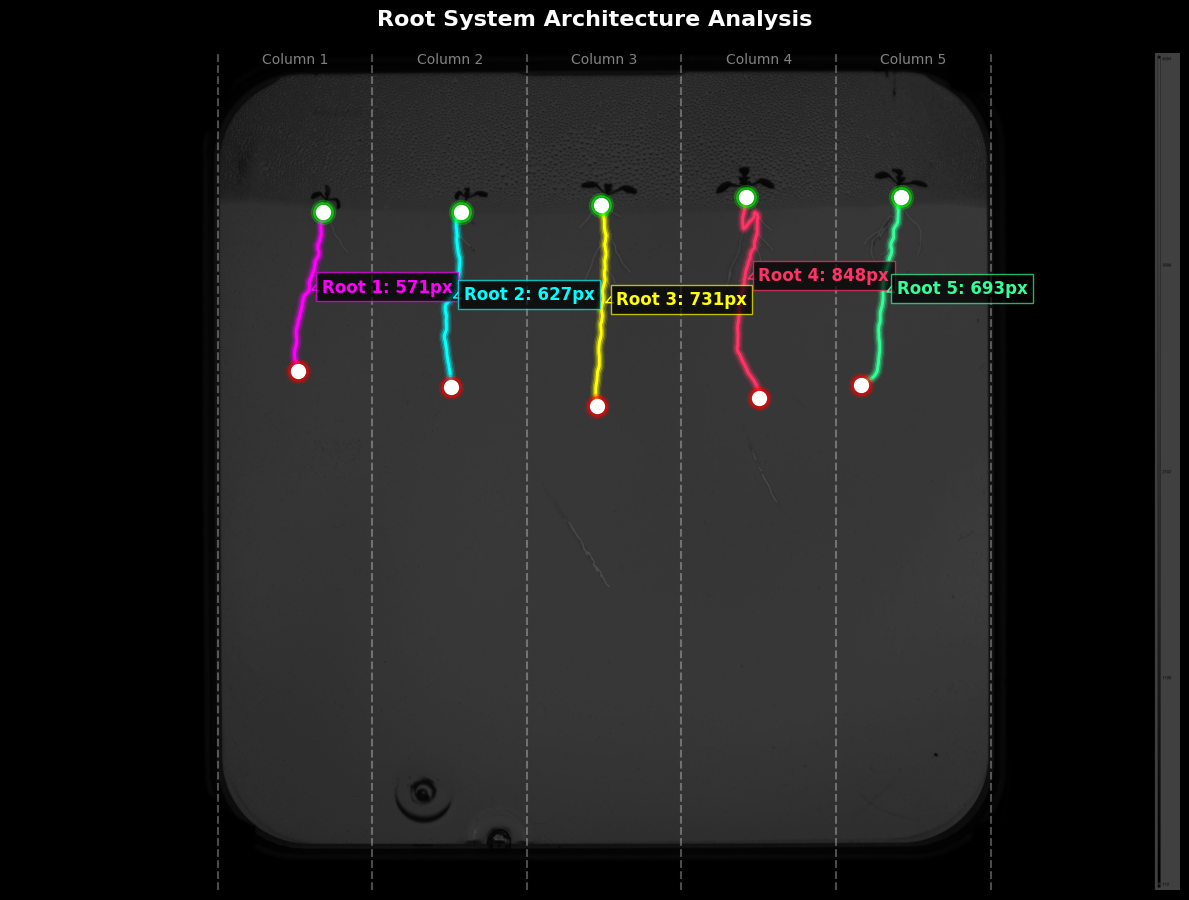

Processing images:  50%|█████     | 9/18 [04:13<03:45, 25.06s/it]

Processing image: test_image_18...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


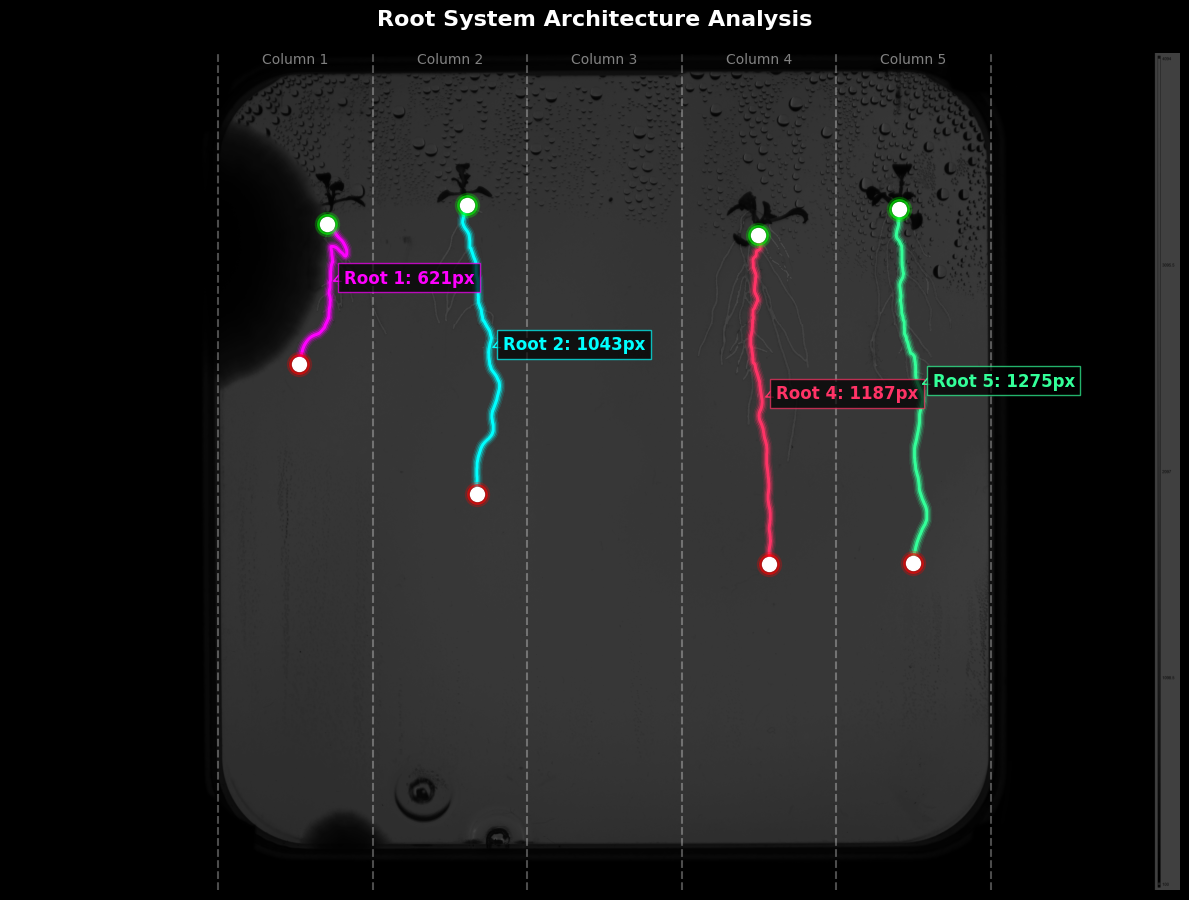

Processing images:  56%|█████▌    | 10/18 [05:39<05:50, 43.80s/it]

Processing image: test_image_2...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)
No valid path found


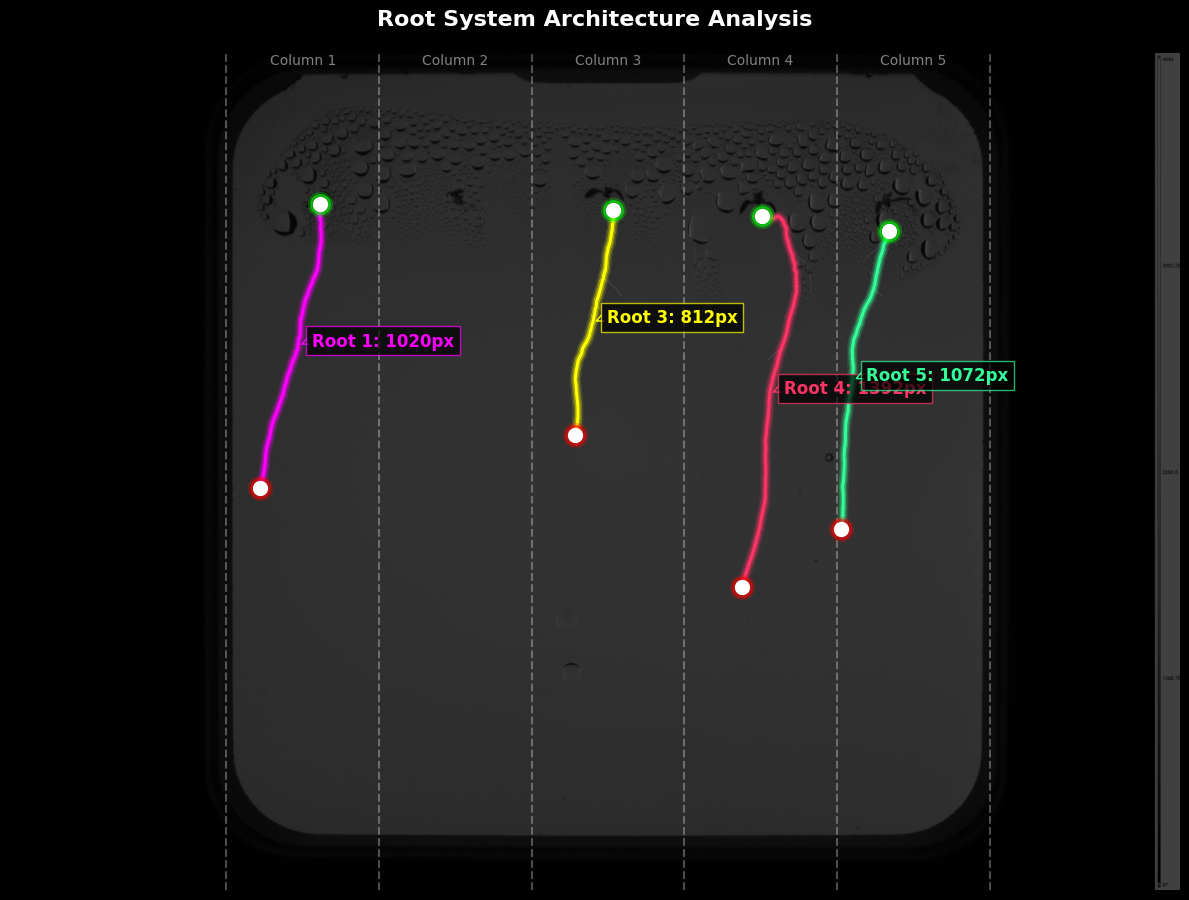

Processing images:  61%|██████    | 11/18 [06:08<04:35, 39.30s/it]

Processing image: test_image_3...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


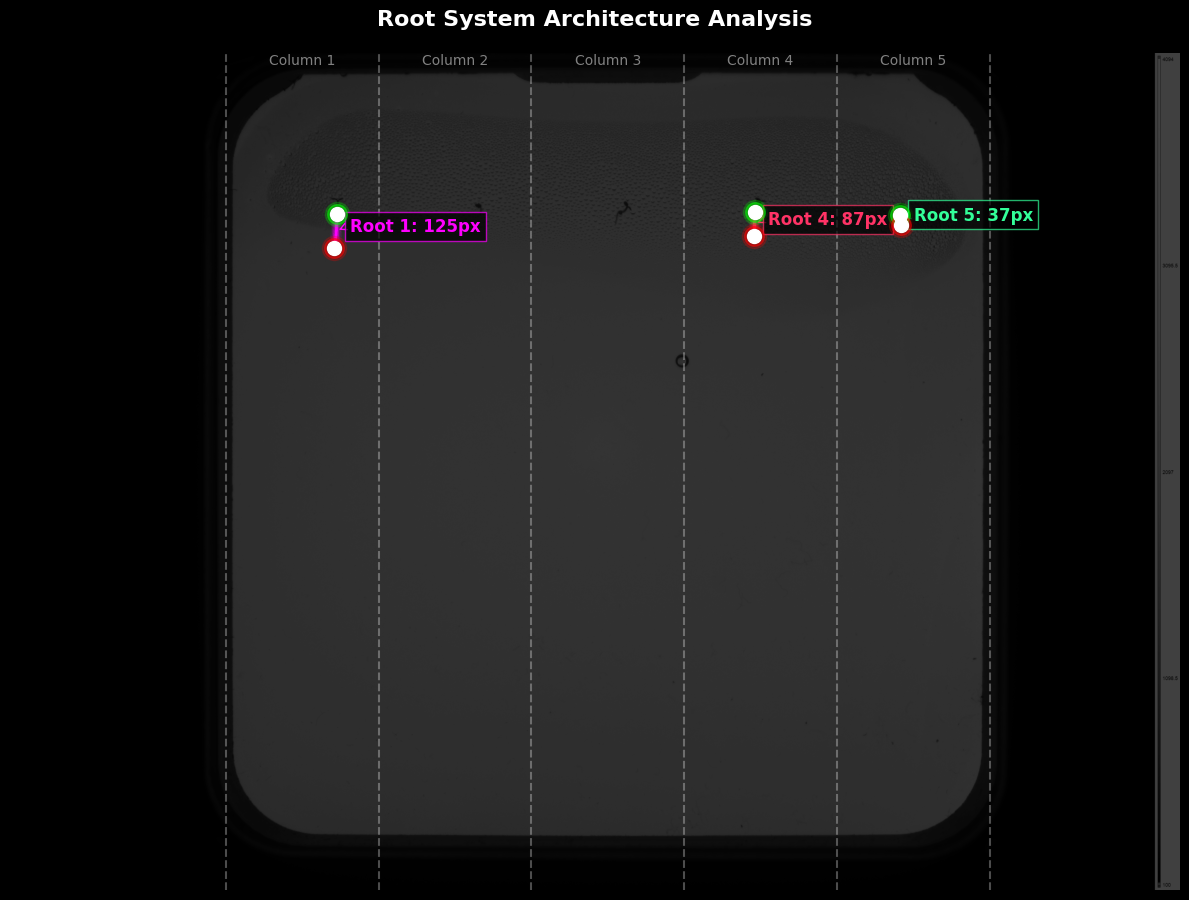

Processing images:  67%|██████▋   | 12/18 [06:16<02:58, 29.74s/it]

Processing image: test_image_4...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


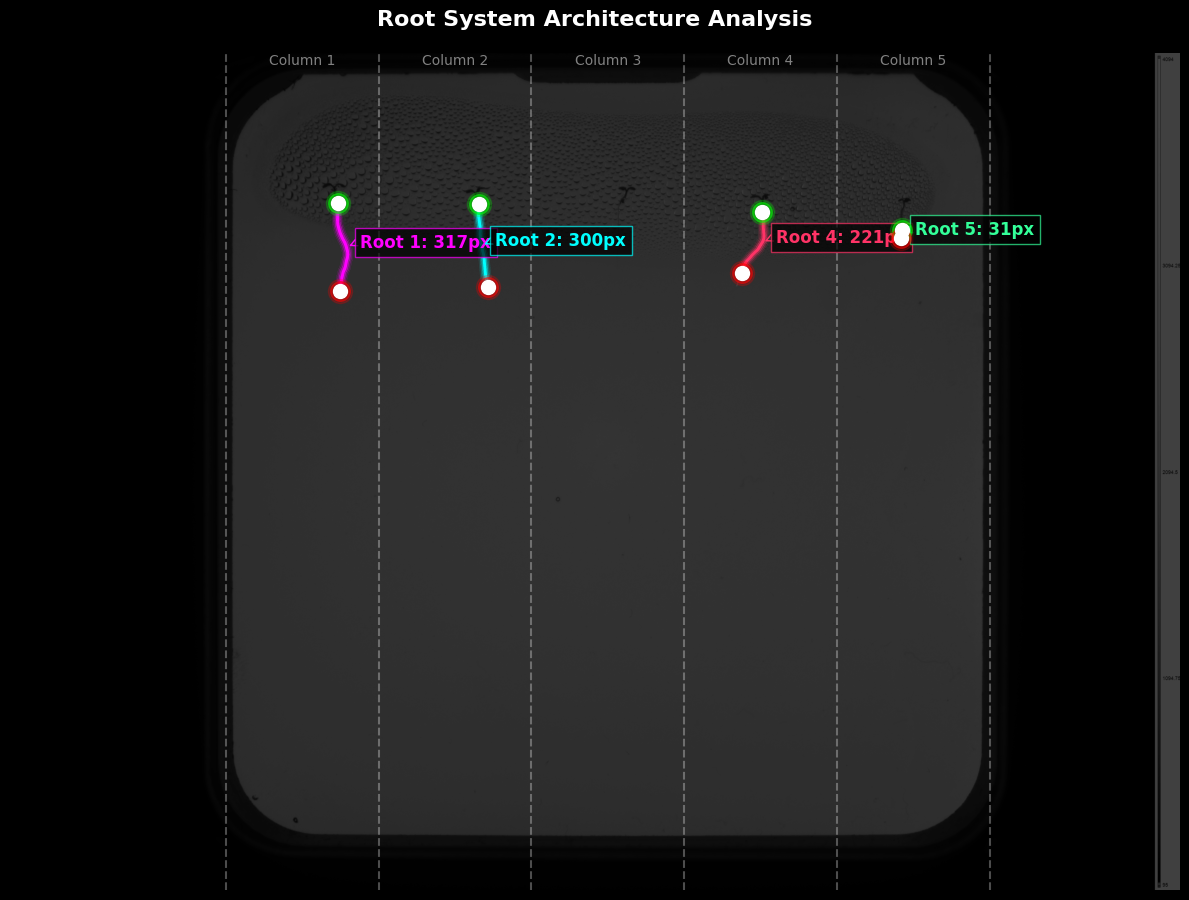

Processing images:  72%|███████▏  | 13/18 [06:26<01:58, 23.78s/it]

Processing image: test_image_5...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


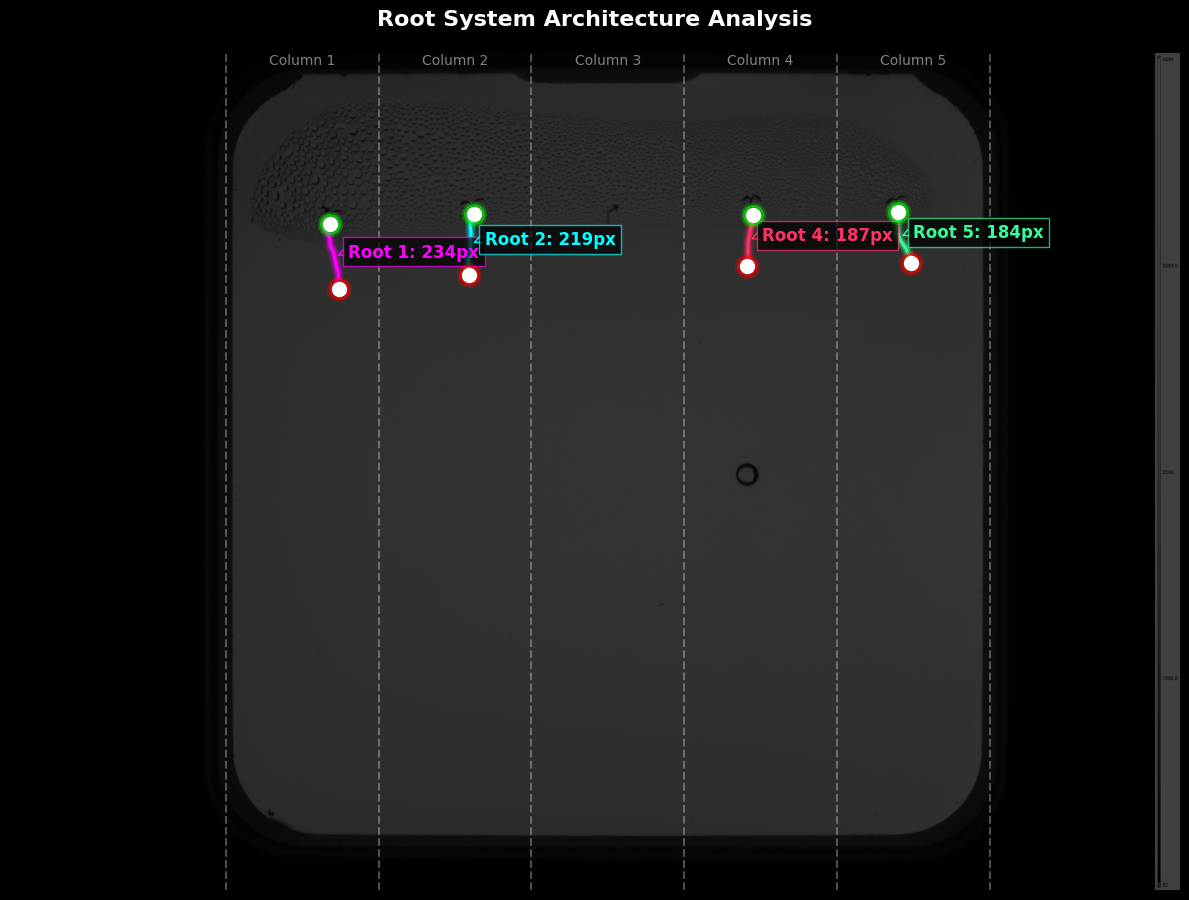

Processing images:  78%|███████▊  | 14/18 [06:35<01:16, 19.16s/it]

Processing image: test_image_6...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


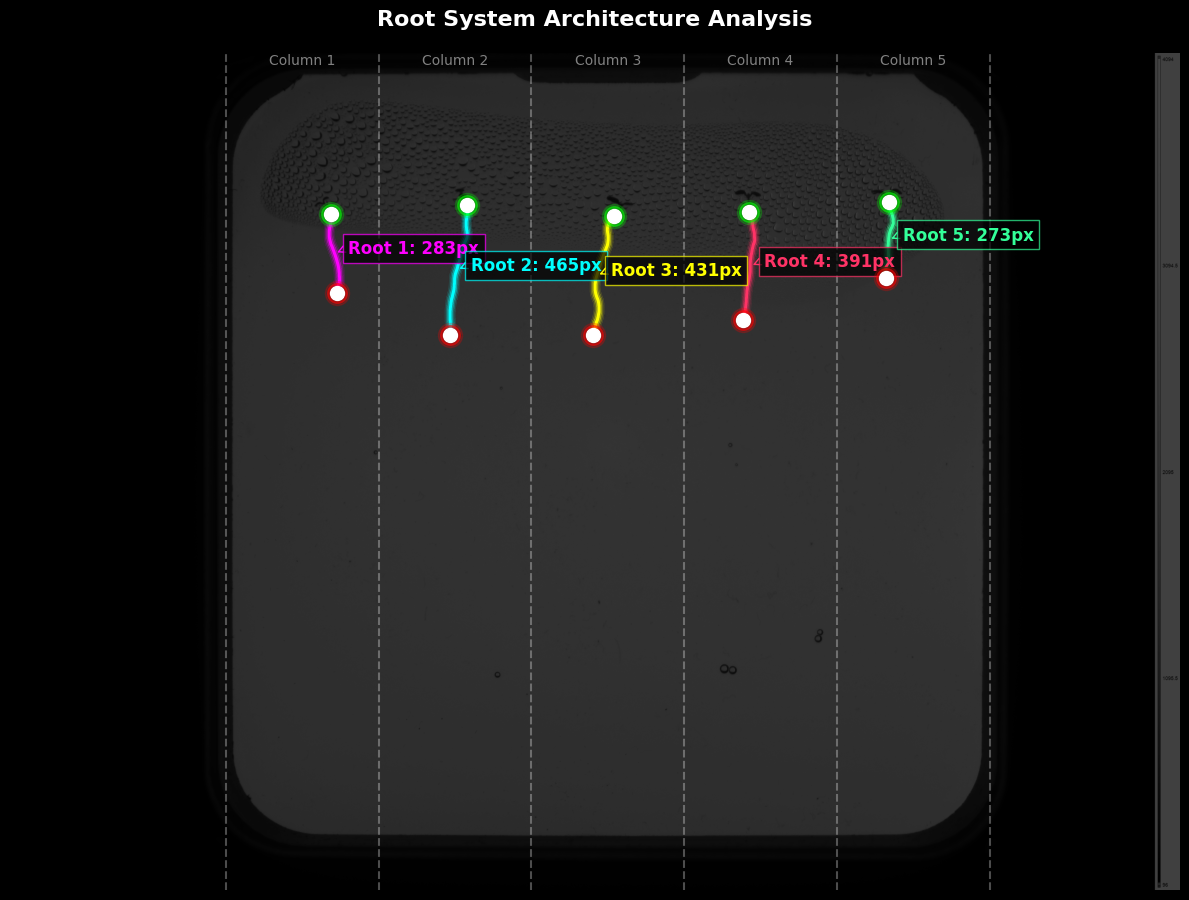

Processing images:  83%|████████▎ | 15/18 [06:46<00:49, 16.64s/it]

Processing image: test_image_7...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


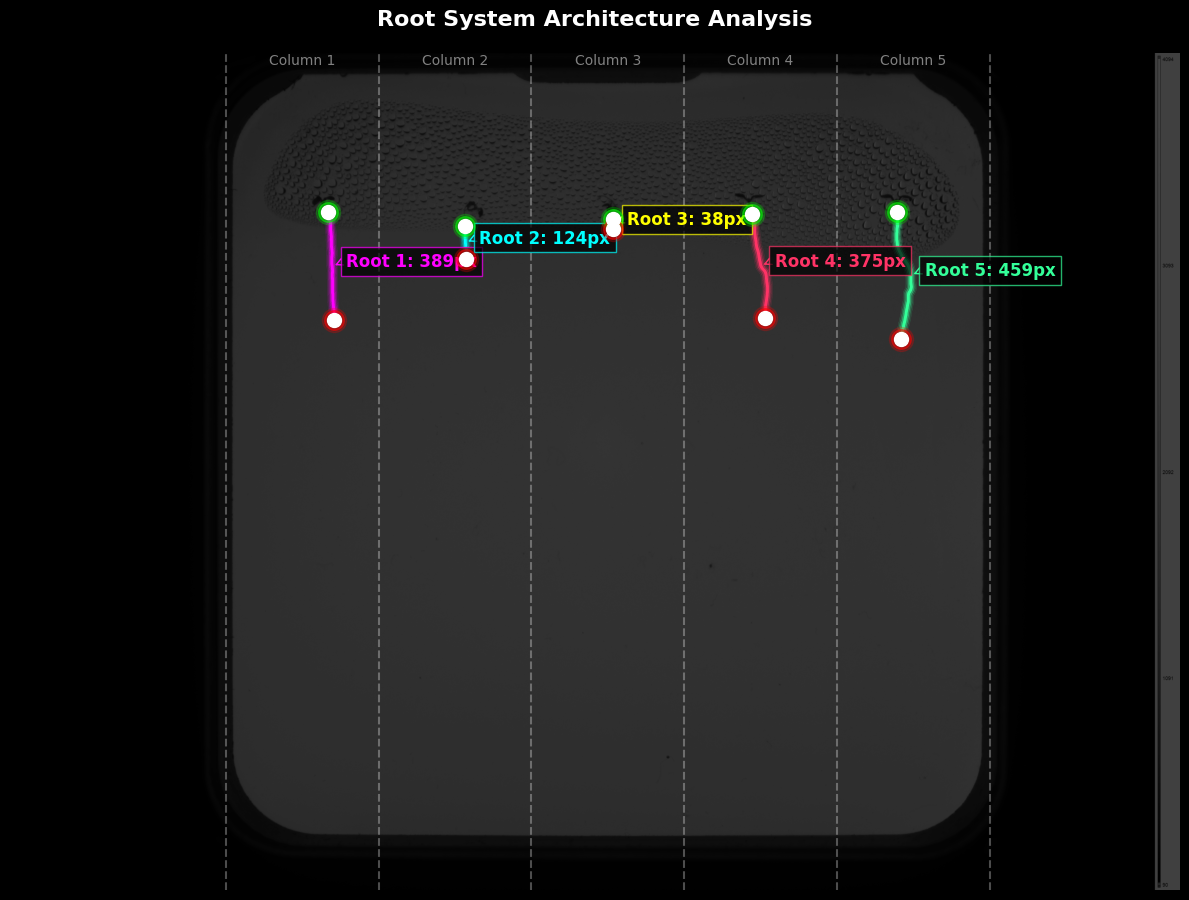

Processing images:  89%|████████▉ | 16/18 [06:57<00:30, 15.15s/it]

Processing image: test_image_8...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


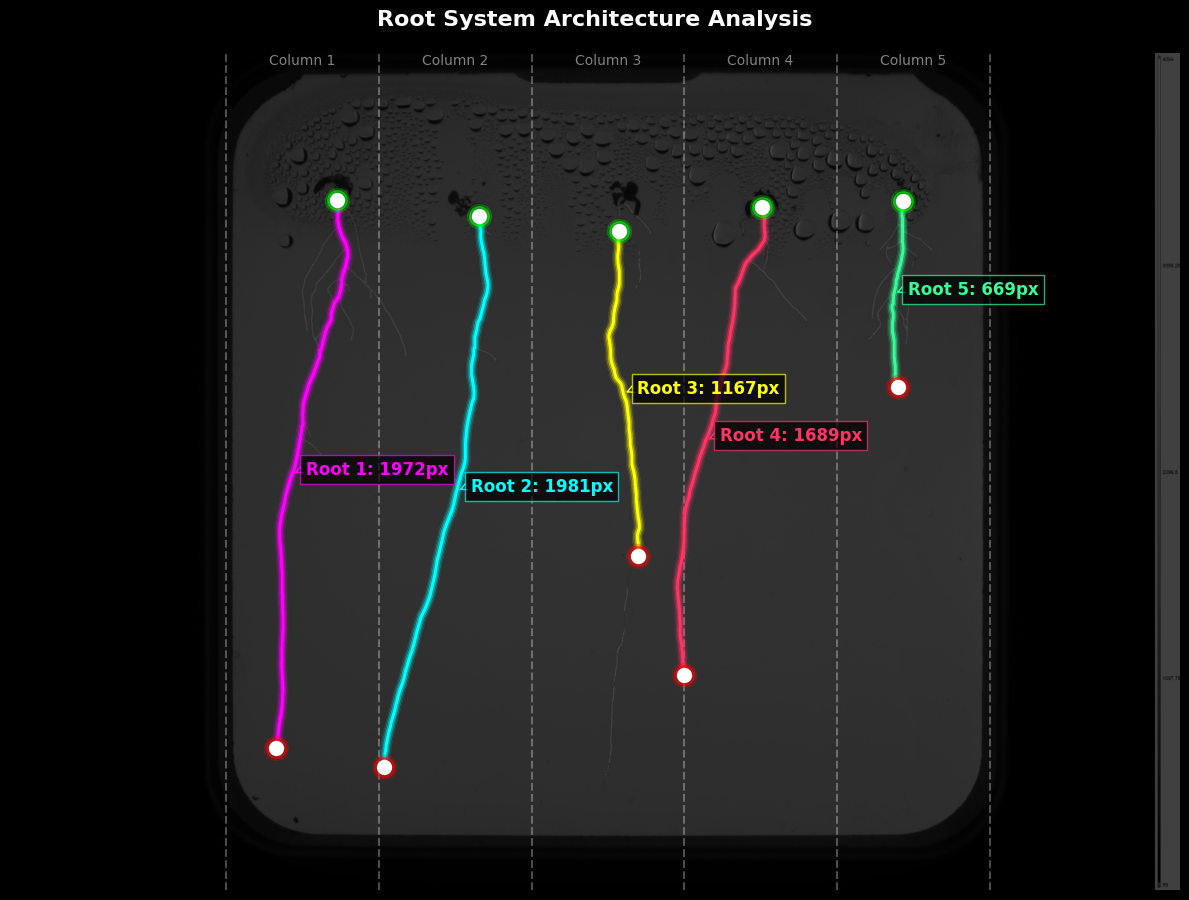

Processing images:  94%|█████████▍| 17/18 [07:54<00:27, 27.65s/it]

Processing image: test_image_9...
Original shape: (2880, 2880, 1)
Patches shape: (3, 3, 960, 960)


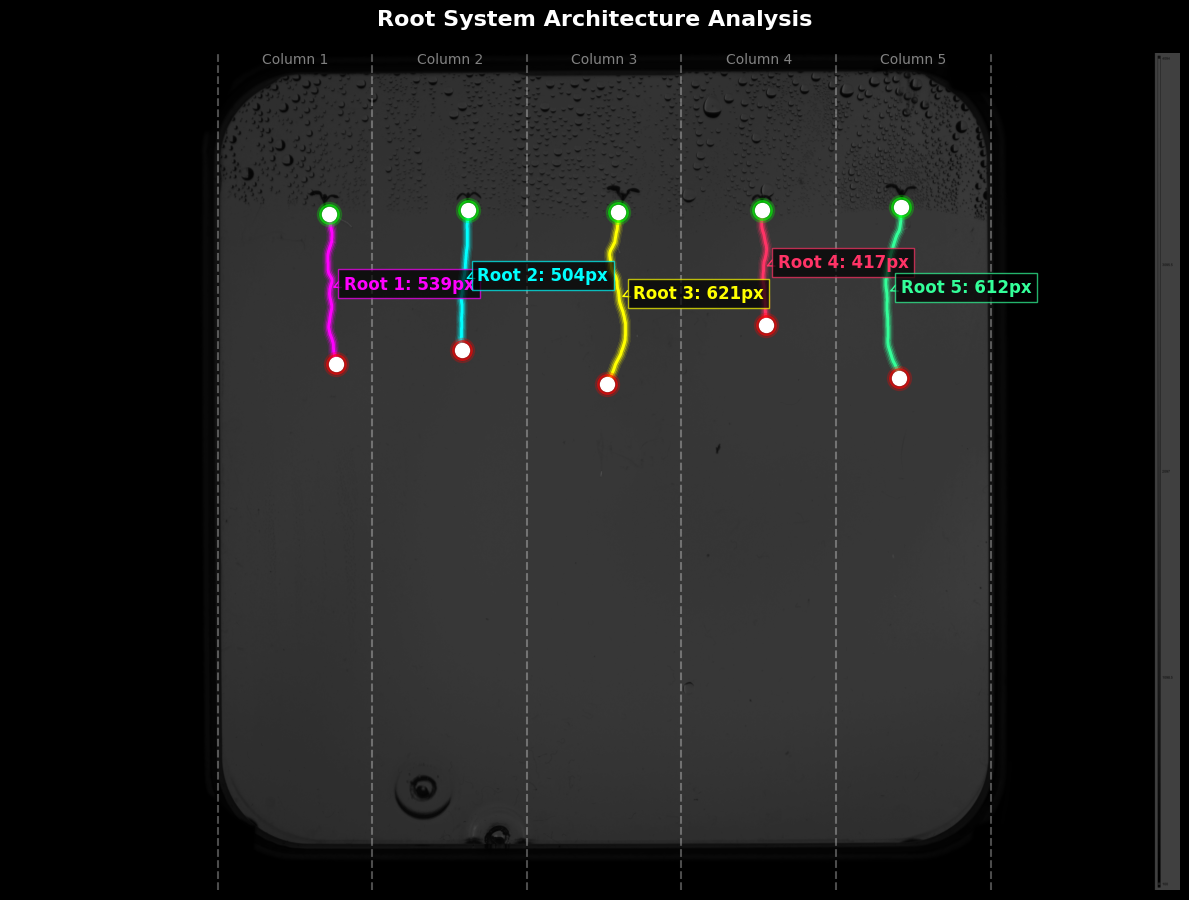

Processing images: 100%|██████████| 18/18 [08:08<00:00, 27.16s/it]


Total plants processed: 90


Plant ID  Length (px)
5   test_image_10_plant_1         1047
6   test_image_10_plant_2         1465
7   test_image_10_plant_3         1192
8   test_image_10_plant_4         1216
9   test_image_10_plant_5         1052
..                    ...          ...
85   test_image_9_plant_1          539
86   test_image_9_plant_2          504
87   test_image_9_plant_3          621
88   test_image_9_plant_4          417
89   test_image_9_plant_5          612

[90 rows x 2 columns]

In [7]:
# Create empty lists to store results
all_plant_ids = []
all_lengths = []

# Get list of all image paths first
image_paths = glob.glob('./../task6/Kaggle/*.png')

# Loop through all images with progress bar
for image_path in tqdm(image_paths, desc="Processing images"):

    # Get image name without extension for reference
    image_name = os.path.basename(image_path).split('.')[0]
    print(f"Processing image: {image_name}...")
    
    # Get predictions
    mask, _ = inference.predict_roots(image_path, model)
    
    # Process the mask and get root data
    analyzer = RootArchitectureAnalyzer()
    # root_data, _ = analyzer.process_image(mask)
    root_data, root_df, tip_coordinates = analyzer.process_image(
        mask=mask,
        original_image=cv2.imread(image_path, 0)  # Load original image in grayscale
    )

    # Visualize the roots
    analyzer.visualize_results(
        root_data=root_data,
        original_mask=mask,
        original_image=cv2.imread(image_path, 0)
    )
    
    # Print structure only for first image (will appear above progress bar)
    if image_path == image_paths[0]:
        print("\nRoot data structure for first plant:")
        print(root_data[0].keys() if root_data else "Empty root_data")
        print("\n")  # Add some space before progress bar
    
    # For each plant in the image
    for plant_num in range(len(root_data)):
        
        # Create plant ID in format "test_image_X_plant_Y"
        plant_id = f"{image_name}_plant_{plant_num + 1}"
        
        # Get the primary root length - using the correct key
        length = root_data[plant_num].get('length', 0)  # we'll update this key based on the output
        
        # Append to lists
        all_plant_ids.append(plant_id)
        all_lengths.append(length)

# Create DataFrame
results_df = pd.DataFrame({
    'Plant ID': all_plant_ids,
    'Length (px)': all_lengths
})

# Sort the DataFrame by Plant ID to match the example
results_df = results_df.sort_values('Plant ID')

# Display the DataFrame
print(f"\nTotal plants processed: {len(results_df)}")
display(results_df)

# Save to CSV
results_df.to_csv('predictions.csv', index=False)